In [5]:
import sys
import warnings
warnings.filterwarnings('ignore')
import joblib
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

import matplotlib.pyplot as plt
import time
import os

PRJ_DIR = os.path.abspath('')

#Load and Preprocessing Test Data

In [30]:
data = pd.read_csv(os.path.join(PRJ_DIR, 'data', 'test', 'data.csv'))

In [8]:
x = data.drop(['result'], axis = 1)
y = data['result']
x = x.values
y = y.values

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
x = scaler.fit_transform(x)

result_map = {'W': 0, 'D': 1, 'L': 2}
y = np.array([result_map[val] for val in y])

In [10]:
def save_model(model, name, folder_path):
    joblib.dump(model, os.path.join(folder_path, name + ".pkl"))
    print("Saved model", name)
def load_model(path):
    return joblib.load(path)

#Scoring Metrics

##Ranked Probability Score

In [13]:
def rps_score(outcomes, predictions):
  loss = 0
  for i, p in enumerate(predictions):
    outcome = [1 if x == outcomes[i] else 0 for x in range(3)]
    tmp = probs = outs = 0
    for j, val in enumerate(predictions[i]):
      probs += val
      outs += outcome[j]
      tmp += (probs - outs) ** 2
    loss += tmp / 2
  loss /= len(predictions)
  return 1 - loss

##Expected Calibration Error and Maximum Calibration Error

In [11]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.7 MB/s eta 0:00:00


In [12]:
from torch import tensor
from torchmetrics.classification import MulticlassCalibrationError

In [ ]:
ece = MulticlassCalibrationError(num_classes=3, n_bins=20, norm='l1')
mce = MulticlassCalibrationError(num_classes=3, n_bins=20, norm='max')

#Evaluation

In [14]:
clf = []
RPS = []
ECE = []
MCE = []

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [15]:
def evaluate(model, name):
  # use model to predict test dataset
  predictions = model.predict_proba(x)

  # calculate score
  rps = rps_score(y, predictions)
  print(name, 'Ranked Probability Score:', rps)

  ece_score = ece(tensor(predictions), tensor(y)).item()
  mce_score = mce(tensor(predictions), tensor(y)).item()
  print(name, 'Expected Calibration Error:', ece_score)
  print(name, 'Maximum Calibration Error:', mce_score)

  # store score
  clf.append(name)
  RPS.append(rps)
  ECE.append(ece_score)
  MCE.append(mce_score)

  # create the calibration curve
  calibration_curve_values = []

  for i in range(3):
      curve = calibration_curve(y == i,
                                predictions[:, i],
                                n_bins=20,
                                pos_label=True)
      calibration_curve_values.append(curve)

  # plot the calibration curves
  fig, axs = plt.subplots(1, 3, figsize=(17,5))
  for i in range(3):
      axs[i].plot(calibration_curve_values[i][1],
                  calibration_curve_values[i][0],
                  marker='o')
      axs[i].plot([0, 1], [0, 1], linestyle='--')
      axs[i].set_xlim([0, 1])
      axs[i].set_ylim([0, 1])
      if i == 0:
          axs[i].set_title("W", fontsize = 17)
      elif i == 1:
          axs[i].set_title("D", fontsize = 17)
      else:
          axs[i].set_title("L", fontsize = 17)
      axs[i].set_xlabel("Predicted probability", fontsize = 15)
      axs[i].set_ylabel("True probability", fontsize = 15)
  plt.tight_layout()
  plt.show()

In [16]:
folder_path = os.path.join(PRJ_DIR, 'model')

Calibrated Random Forest Ranked Probability Score: 0.7537886853816654
Calibrated Random Forest Expected Calibration Error: 0.34002062678337097
Calibrated Random Forest Maximum Calibration Error: 0.4598603844642639


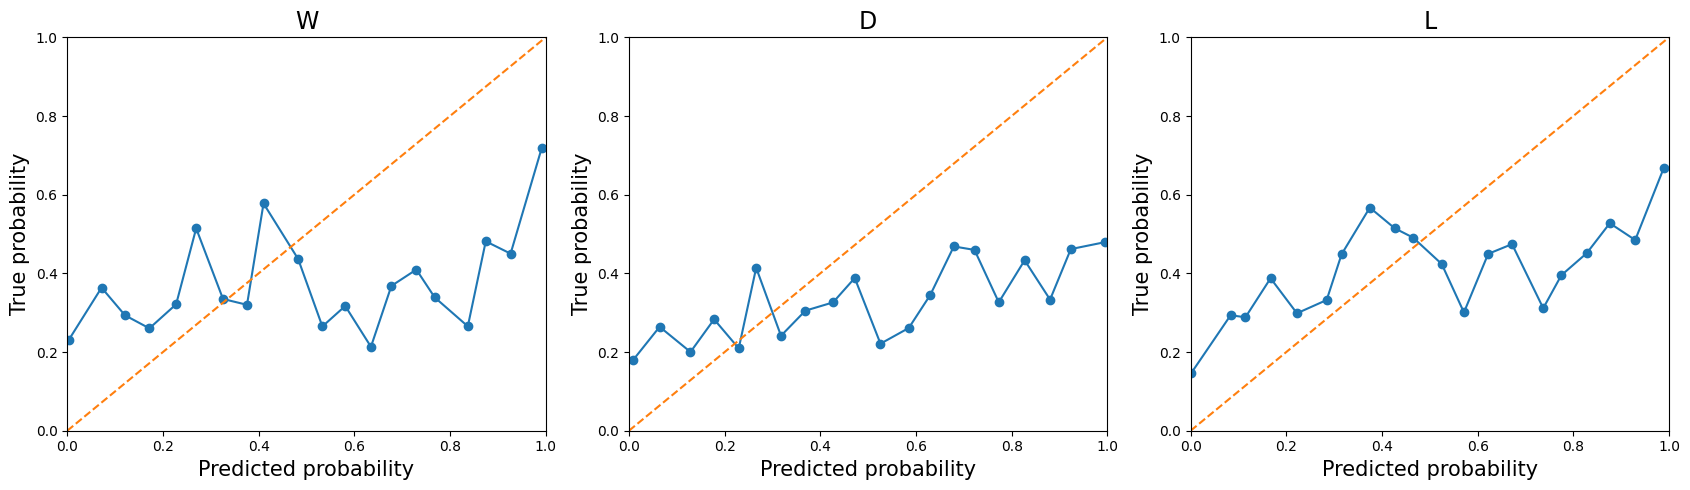

Calibrated XGBoost Ranked Probability Score: 0.6512471369473538
Calibrated XGBoost Expected Calibration Error: 0.491166889667511
Calibrated XGBoost Maximum Calibration Error: 0.6092690229415894


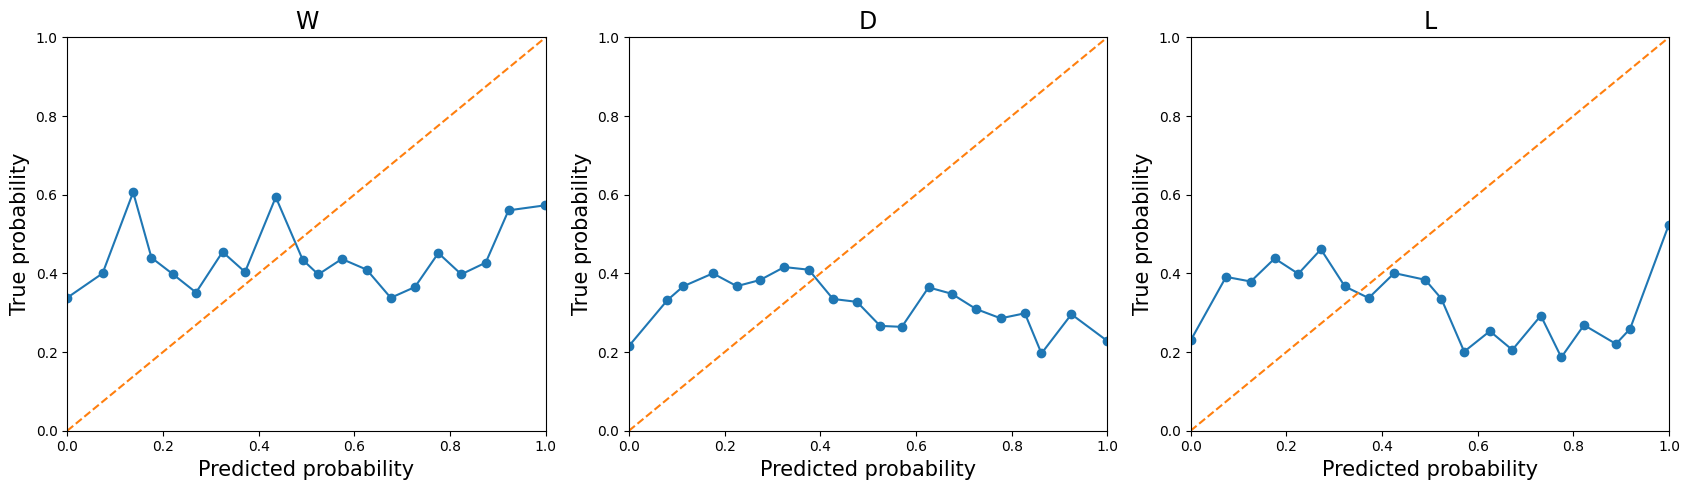

K Nearest Neighbors Ranked Probability Score: 0.7279670453222167
K Nearest Neighbors Expected Calibration Error: 0.38457271456718445
K Nearest Neighbors Maximum Calibration Error: 0.6380469799041748


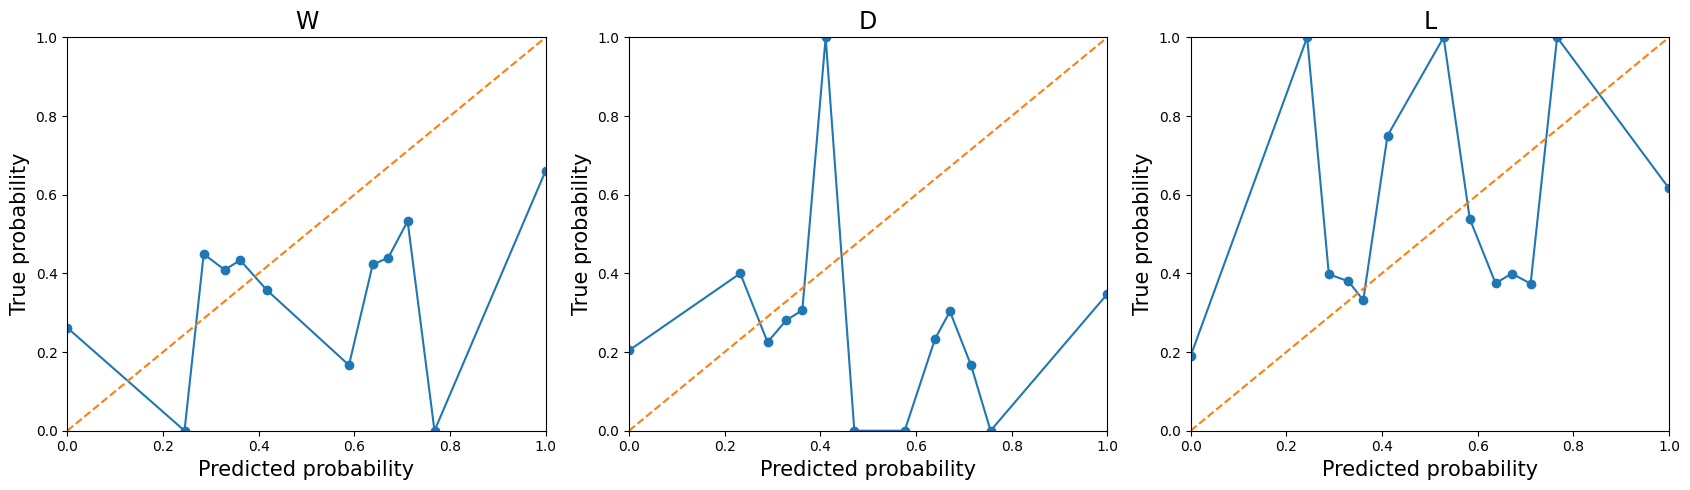

XGBoost Ranked Probability Score: 0.6867466613874846
XGBoost Expected Calibration Error: 0.42700937390327454
XGBoost Maximum Calibration Error: 0.5163116455078125


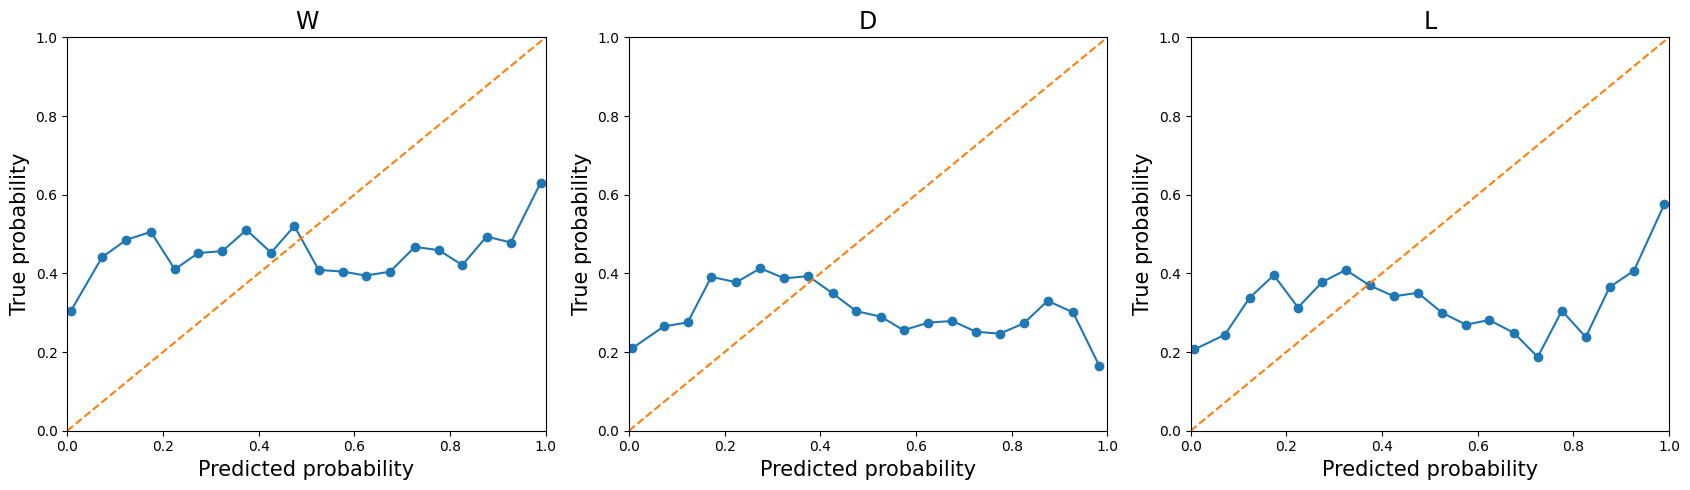

Calibrated Decision Tree Ranked Probability Score: 0.8186003022332162
Calibrated Decision Tree Expected Calibration Error: 0.1688305139541626
Calibrated Decision Tree Maximum Calibration Error: 0.6820960640907288


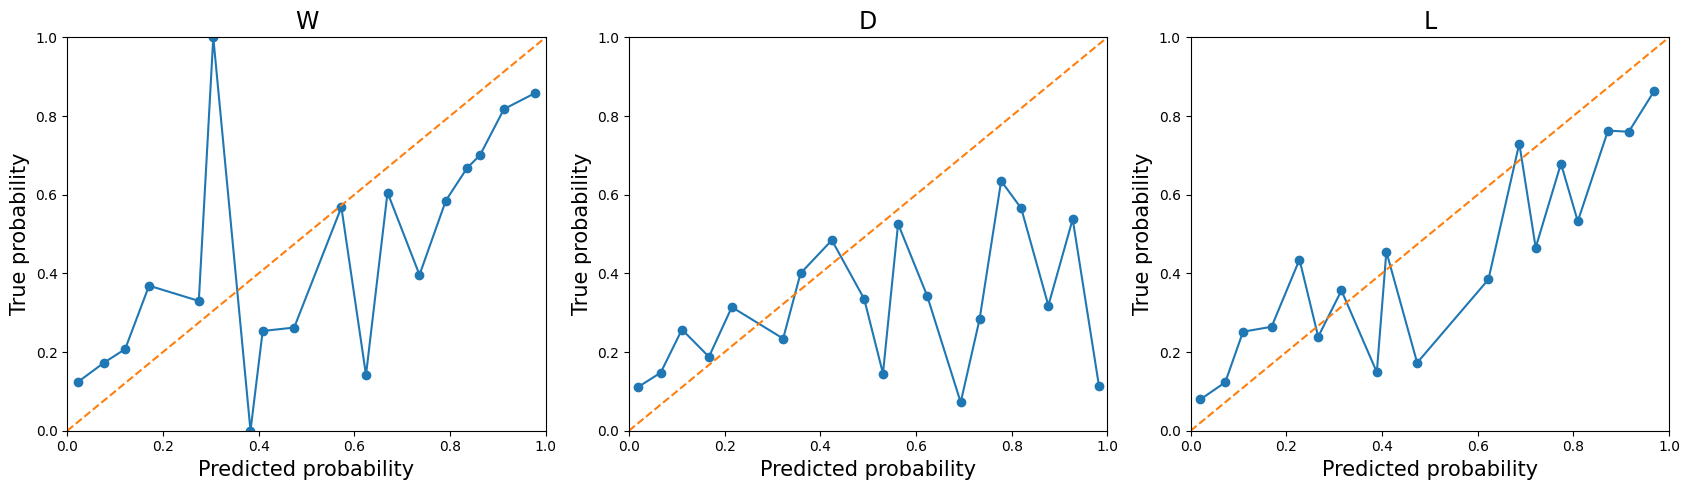

Calibrated K Nearest Neighbors Ranked Probability Score: 0.7277321902269949
Calibrated K Nearest Neighbors Expected Calibration Error: 0.3855555057525635
Calibrated K Nearest Neighbors Maximum Calibration Error: 0.6773965358734131


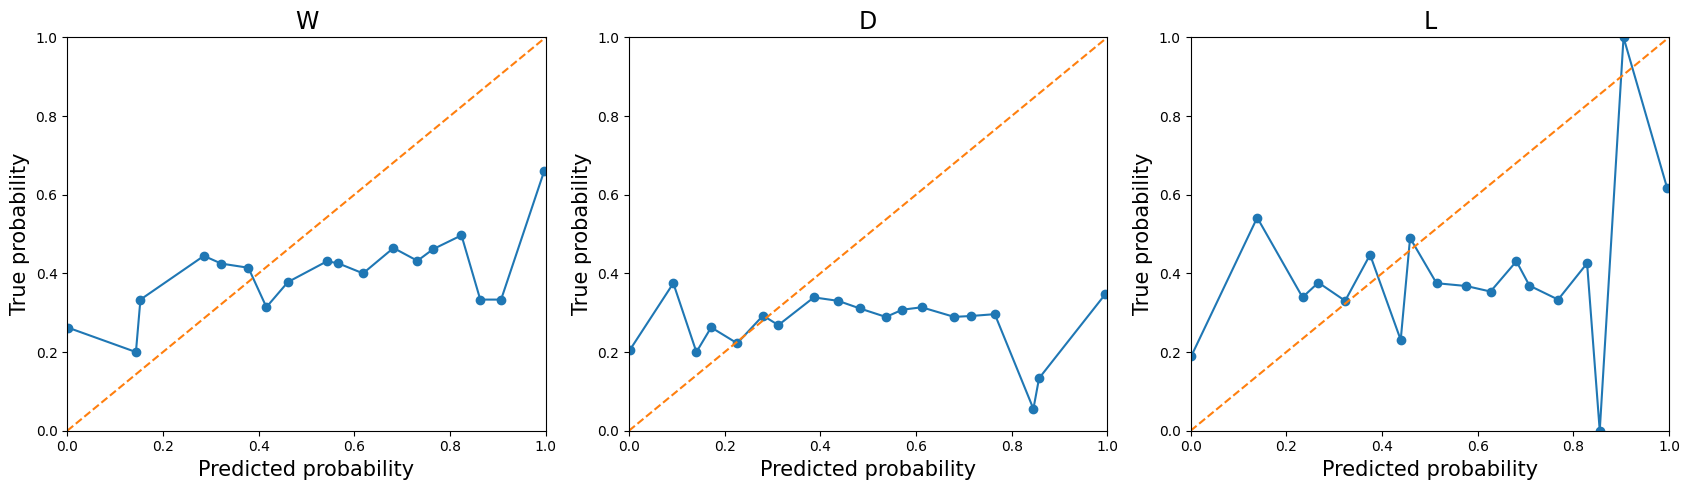

Decision Tree Ranked Probability Score: 0.8178499195746859
Decision Tree Expected Calibration Error: 0.17158308625221252
Decision Tree Maximum Calibration Error: 0.6820960640907288


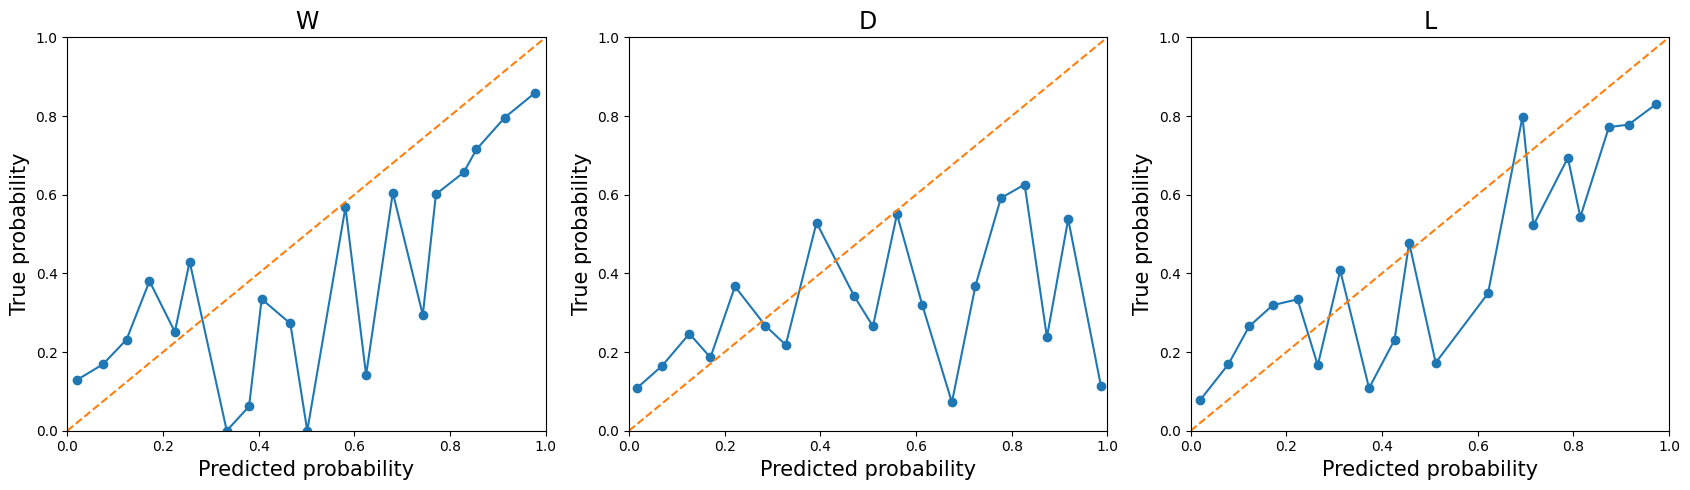

Random Forest Ranked Probability Score: 0.8040439394036195
Random Forest Expected Calibration Error: 0.17952680587768555
Random Forest Maximum Calibration Error: 0.3092072010040283


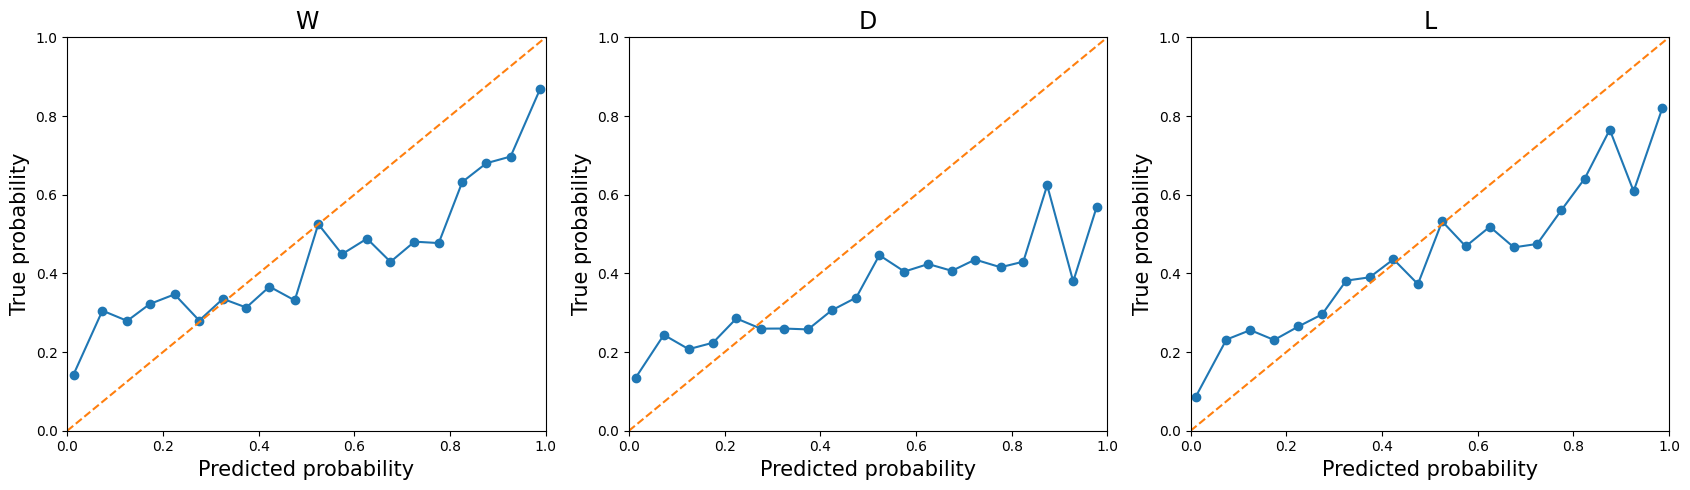

In [18]:
for model_path in os.listdir(folder_path):
  model = load_model(os.path.join(folder_path, model_path))
  evaluate(model, model_path[:-4])

In [31]:
# save model for demo
save_model(load_model(os.path.join(folder_path, 'XGBoost.pkl')), 'demo_model', folder_path)

Saved model demo_model


# Display result

In [25]:
data = {
    'Classifier': clf,
    'RPS': RPS,
    'ECE': ECE,
    'MCE': MCE
}
df = pd.DataFrame(data)
df = df.reset_index(drop=True)
df

,Classifier,RPS,ECE,MCE
0,Calibrated Random Forest,0.753789,0.340021,0.459860
1,Calibrated XGBoost,0.651247,0.491167,0.609269
2,K Nearest Neighbors,0.727967,0.384573,0.638047
3,XGBoost,0.686747,0.427009,0.516312
4,Calibrated Decision Tree,0.818600,0.168831,0.682096
5,Calibrated K Nearest Neighbors,0.727732,0.385556,0.677397
6,Decision Tree,0.817850,0.171583,0.682096
7,Random Forest,0.804044,0.179527,0.309207


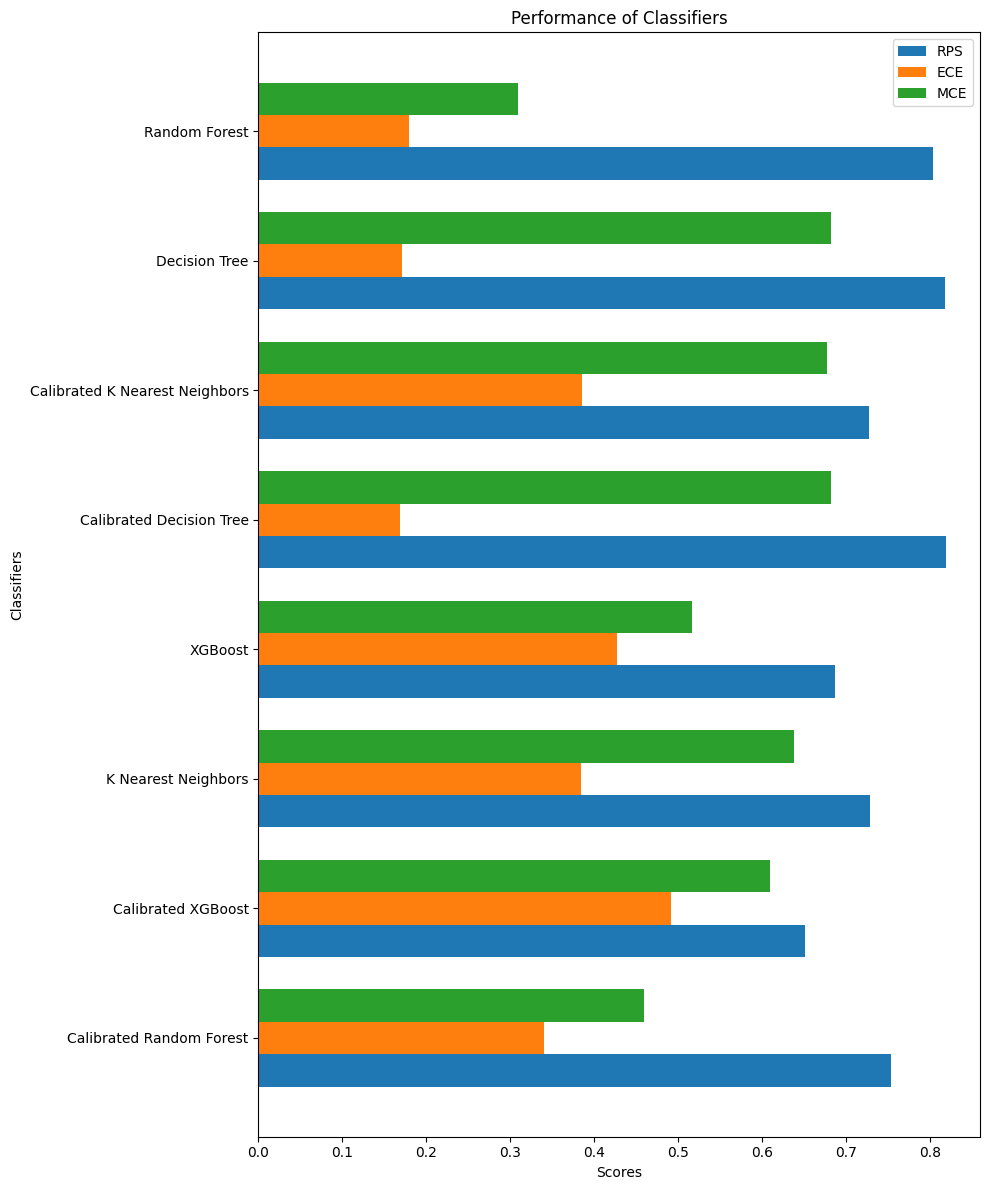

In [29]:
# creating an array for the y-axis positions
y = np.arange(len(df))

# adjust plot
plt.figure(figsize=(10, 12))
bar_width = 0.25

# score bars
plt.barh(y - bar_width, df['RPS'], height=bar_width, label='RPS')
plt.barh(y, df['ECE'], height=bar_width, label='ECE')
plt.barh(y + bar_width, df['MCE'], height=bar_width, label='MCE')

# label plot
plt.xlabel('Scores')
plt.ylabel('Classifiers')
plt.title('Performance of Classifiers')
plt.yticks(y, df['Classifier'])
plt.legend()

plt.tight_layout()
plt.show()